In [419]:
%matplotlib notebook
import numpy as np
import operator
import scipy
import scipy.ndimage
import matplotlib.patches
from scipy.spatial import distance
import photutils
from photutils import centroid_com
from scipy import ndimage
import h5py
import matplotlib
import matplotlib.pyplot as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
from scipy.ndimage.morphology import binary_fill_holes
import os, re
import sys
sourcepath = '/Users/niloo/Desktop/SwissFel_2019/data_beamtime/SwissFEL_BERNINA_20181820-master/src'
sys.path.insert(0, sourcepath)
import calibrators
from calibrators import *

In [2]:
files = {'r0144':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0144_type1-peaks_with_q.h5',
         'r0145':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0145_type1-peaks_with_q.h5',
         'r0146':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0146_type1-peaks_with_q.h5',
         'r0147':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0147_type1-peaks_with_q.h5',
         'r0151':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0151_type1-peaks_with_q.h5',
         'r0165':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0165_type1-peaks_with_q.h5',
         'r0166':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0166_type1-peaks_with_q.h5',
         'r0167':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0167_type1-peaks_with_q.h5',
         'r0168':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0168_type1-peaks_with_q.h5',
         'r0169':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0169_type1-peaks_with_q.h5',
         'r0170':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0170_type1-peaks_with_q.h5',
         'r0171':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0171_type1-peaks_with_q.h5',
         'r0172':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0172_type1-peaks_with_q.h5',
         'r0173':'/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0173_type1-peaks_with_q.h5'}

f_tuples = sorted(files.items(), key=operator.itemgetter(1))
runs = sorted(np.array([n[0] for n in f_tuples]))
files_pass = np.array([n[1] for n in sorted(f_tuples)])

### wavelength should be corrected in the files, they are not in Angstrom

In [3]:
def load_runs(run,path=None, lower_bound=None, upper_bound=None):
    '''
    loads data from processed h5
    '''
    
    if path is None:
        h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    else:
        h5path = path+'%s_type1-peaks.h5'%run
    h5file = h5py.File(h5path,'r')
    wavelength = h5file['LCLS/wavelengthInAngstromMean'][()]/1e10
    n_shots = h5file['LCLS/numberOfShots'][()]
    detector_distance = h5file['LCLS/detectorDistanceInMeterMean'][()]
    n_peaks = []
    peak_list = []
    center_mass = []
    radius = []
    q_cm = []
    shots = [x for x in h5file['shots'].keys()]
    if (lower_bound is not None) and (upper_bound is not None):
        shots_in_bounds = []
    else:
        shots_in_bounds = None
    for i,j in enumerate(shots):
        n_peaks.append(h5file['shots'][j]['numberOfPeaks'][()])
        each_shot = [key for key in h5file['shots'][j].keys()]
        for i in each_shot:
            if (len(i) <= 12) & (i.startswith('peak')):
                peak_list.append(h5file['shots'][j][i]['diffraction'][:])
                center_mass.append(h5file['shots'][j][i]['centerOfMassInPixels'][:])
                radius.append(h5file['shots'][j][i]['radiusInPixels'][()])
                q_cm.append(h5file['shots'][j][i]['peakCenterOfMassQMagnitude'][:])
                if (lower_bound is not None) and (upper_bound is not None):
                    if np.any((h5file['shots'][j][i]['peakCenterOfMassQMagnitude'][:] >= lower_bound) & ( h5file['shots'][j][i]['peakCenterOfMassQMagnitude'][:] < upper_bound)):
                        shots_in_bounds.append(j)
    print('run %s: %d shots, %d peaks' % (run, n_shots, sum(n_peaks)))
    h5file.close()    
    return  {'peaks': peak_list,
             'wavelength': wavelength,
             'detector_distance': detector_distance,
             'center_mass': center_mass,
             'q_cm': q_cm,
             'No_of_peaks': n_peaks,
             'shots_bounds': shots_in_bounds,
             'radiusInPixels': radius}

In [4]:
run_list = {}
for n in files.keys():
    print("---------- %s ----------" % n)
    run_list[n] = load_runs(n)

---------- r0144 ----------
run r0144: 51 shots, 433 peaks
---------- r0145 ----------
run r0145: 42 shots, 369 peaks
---------- r0146 ----------
run r0146: 22 shots, 185 peaks
---------- r0147 ----------
run r0147: 266 shots, 2557 peaks
---------- r0151 ----------
run r0151: 127 shots, 1162 peaks
---------- r0165 ----------
run r0165: 2865 shots, 23205 peaks
---------- r0166 ----------
run r0166: 630 shots, 3160 peaks
---------- r0167 ----------
run r0167: 786 shots, 3378 peaks
---------- r0168 ----------
run r0168: 625 shots, 2728 peaks
---------- r0169 ----------
run r0169: 499 shots, 3408 peaks
---------- r0170 ----------
run r0170: 140 shots, 948 peaks
---------- r0171 ----------
run r0171: 433 shots, 3008 peaks
---------- r0172 ----------
run r0172: 749 shots, 5223 peaks
---------- r0173 ----------
run r0173: 1705 shots, 7462 peaks


In [6]:
T_w = ['r0144','r0145','r0146', 'r0147', 'r0151','r0169','r0170']
T_m = ['r0167', 'r0168', 'r0171', 'r0172', 'r0173']
T_c = ['r0165','r0166']

In [7]:
run_with_lims = {}
for n in T_c:
    print("---------- %s ----------" % n)
    run_with_lims[n] = load_runs(n, lower_bound=0.7, upper_bound=1.0)

---------- r0165 ----------
run r0165: 2865 shots, 23205 peaks
---------- r0166 ----------
run r0166: 630 shots, 3160 peaks


In [8]:
run_lims_w = {}
for n in T_w:
    print("---------- %s ----------" % n)
    run_lims_w[n] = load_runs(n, lower_bound=0.7, upper_bound=0.9)

---------- r0144 ----------
run r0144: 51 shots, 433 peaks
---------- r0145 ----------
run r0145: 42 shots, 369 peaks
---------- r0146 ----------
run r0146: 22 shots, 185 peaks
---------- r0147 ----------
run r0147: 266 shots, 2557 peaks
---------- r0151 ----------
run r0151: 127 shots, 1162 peaks
---------- r0169 ----------
run r0169: 499 shots, 3408 peaks
---------- r0170 ----------
run r0170: 140 shots, 948 peaks


In [13]:
run_lims_w['r0145']['shots_bounds']

[]

In [9]:
len(set(run_with_lims['r0166']['shots_bounds'])), len(set(run_with_lims['r0166']['shots_bounds']))

(7, 7)

In [10]:
os.getcwd()

'/Users/niloo/Desktop/LCLS/14Dec2020'

In [11]:
s = set(run_with_lims['r0166']['shots_bounds'])

In [12]:
s2 = set(run_lims_w['r0145']['shots_bounds'])

In [778]:
'''
textfile = open("r0165_shots_with_low-q_bounds.txt", "w")
for element in s2:
    textfile.write(element + "\n")
textfile.close()
'''

In [13]:
seen = set()
uniq = [x for x in run_with_lims['r0165']['shots_bounds'] if x in seen or seen.add(x)]    

In [14]:
len(uniq)

2503

<IPython.core.display.Javascript object>


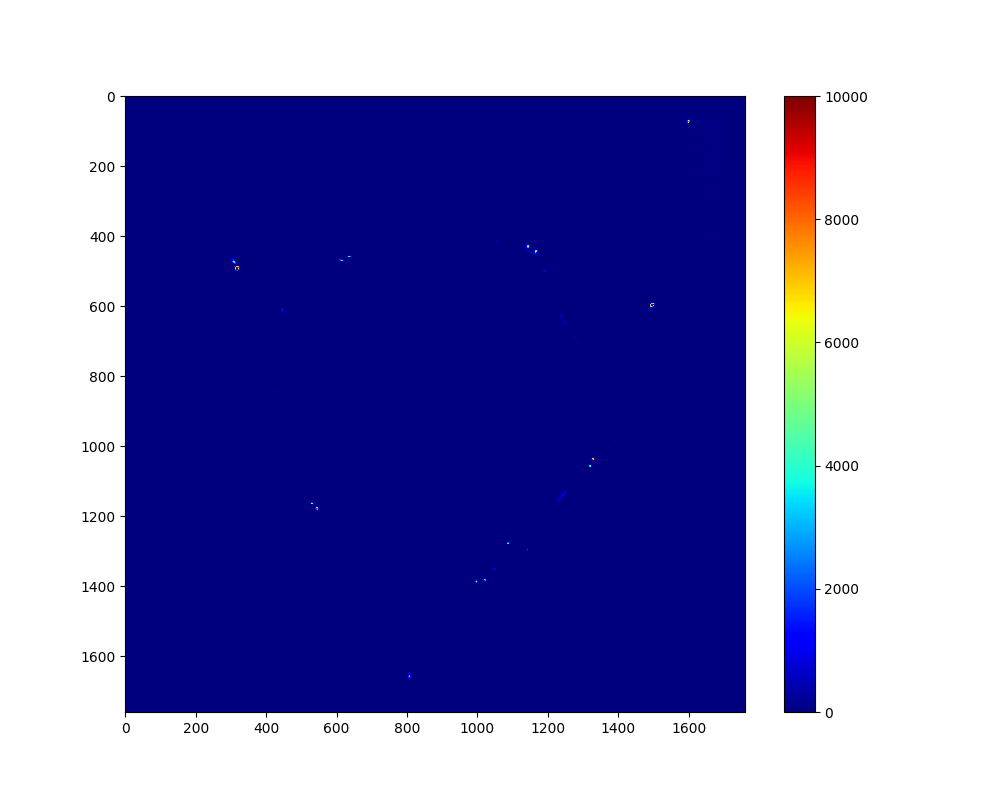

In [311]:

f = h5py.File('/Volumes/harddrive/LCLS/CXI/cxi25410/res/iceFinderCampaign/output_r0166/type1/LCLS_2011_Mar01_r0166_000133_103aa_cspad.h5', 'r')
d = f['data/data'][:]
plt.figure(figsize=[10,8])
plt.imshow(d,cmap='jet', vmin=0, vmax=10000, origin = 'lower', aspect='auto')
plt.colorbar();
plt.gca().invert_yaxis()

plt.show()


In [16]:
q_cm_w = []
for i,n in enumerate(T_w):
    q_cm_w.append(run_list[n]['q_cm'])

In [17]:
q_cm_m = []
for i,n in enumerate(T_m):
    q_cm_m.append(run_list[n]['q_cm'])

In [18]:
q_cm_c = []
for i,n in enumerate(T_c):
    q_cm_c.append(run_list[n]['q_cm'])

In [19]:
import itertools
q_cm_w = np.array(sorted(itertools.chain(*q_cm_w))).T
q_cm_m = np.array(sorted(itertools.chain(*q_cm_m))).T
q_cm_c = np.array(sorted(itertools.chain(*q_cm_c))).T

In [92]:
#q_cm_c[np.where(yhist_c == 659)]

<IPython.core.display.Javascript object>


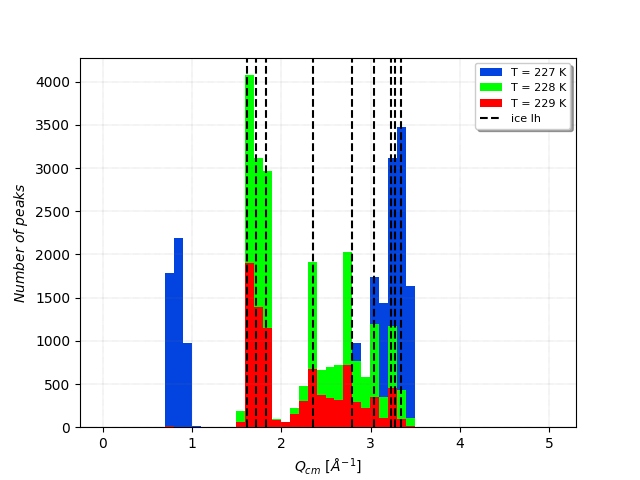

In [109]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.01
binedges = np.arange(0-binwidth/2,5.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(q_cm_w, bins=binedges)
yhist_m, bin_edges_m = np.histogram(q_cm_m, bins=binedges)
yhist_c, bin_edges_c = np.histogram(q_cm_c, bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

T_227 = plt.bar(new_bins, new_q_cm_c,  color='#0343DF', width=binwidth*10, label= 'T = 227 K')
T_228 = plt.bar(new_bins, new_q_cm_m,  color='#00FF00', width=binwidth*10, label = 'T = 228 K')
T_229 = plt.bar(new_bins, new_q_cm_w,  color='r', width=binwidth*10, label = 'T = 229 K')
xposition = iceIh_peaks()
for xc in xposition[:-1]:
    ice_plot = plt.axvline(x=xc, color='k', linestyle='--')

plt.legend(handles=[T_227, T_228, T_229, ice_plot], labels=['T = 227 K', 'T = 228 K', 'T = 229 K', 'ice Ih'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q_{cm}\ [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


In [110]:
#plt.imshow(sphericity_of_peak[265][0],cmap='jet')

In [111]:
def aspect_ratio(run_group):
    sphericity_of_peak = []
    for n, run in enumerate(run_group):
        p = run_list[run]['peaks']
        c_mass = run_list[run]['center_mass']
        for p_i in np.arange(len(p)):
            p_sub = p[p_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    #cnt_string = 'Numbers of contours for peak {} : {}, sphericity: {}'
                    #print(cnt_string.format(p_i, len(contours), sphericity))
                    sphericity_of_peak.append(sphericity)
    return sphericity_of_peak

<IPython.core.display.Javascript object>


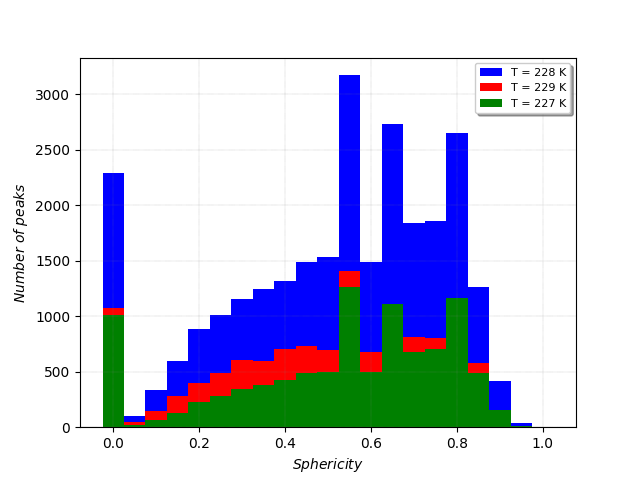

In [112]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(aspect_ratio(T_w), bins=binedges)
Sp_m, bin_edges = np.histogram(aspect_ratio(T_m), bins=binedges)
Sp_c, bin_edges = np.histogram(aspect_ratio(T_c), bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K')
plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [26]:
BG_level = 100
photon_threshold = 2000
sphericity_of_peak = []
for n, run in enumerate(run_list.keys()):
    p = run_list[run]['peaks']
    c_mass = run_list[run]['center_mass']
    for p_i in np.arange(len(p)):
        p_sub = p[p_i] - BG_level
        p_mask = p_sub > photon_threshold
        fill_holes = binary_fill_holes(p_mask)
        contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for cnt in contours:
            perimeter = cv2.arcLength(cnt, True)
            area = cv2.contourArea(cnt)
            if perimeter != 0:
                sphericity = 4*np.pi*area/(perimeter**2)     
                #cnt_string = 'Numbers of contours for peak {} : {}, sphericity: {}'
                #print(cnt_string.format(p_i, len(contours), sphericity))
                sphericity_of_peak.append((p[p_i],len(contours),sphericity))

In [27]:
# print the center of mass of the peaks inside each shot the coordinates are given in the whole image 1760
for n, run in enumerate(run_list.keys()):
    print(np.shape(run_list[run]['center_mass']))

(433, 2)
(369, 2)
(185, 2)
(2557, 2)
(1162, 2)
(23205, 2)
(3160, 2)
(3378, 2)
(2728, 2)
(3408, 2)
(948, 2)
(3008, 2)
(5223, 2)
(7462, 2)


In [28]:
S_p = np.array([sphericity_of_peak[i][2] for i in range(len(sphericity_of_peak))])

In [29]:
# calculate qx and qy to find distance
wavelength = np.array([run_list[run]['wavelength'] for run in run_list.keys()])
detector_distance = np.array([run_list[run]['detector_distance'] for run in run_list.keys()])
wavelength = np.mean(wavelength)
detector_distance = np.mean(detector_distance)
pixel_size = 109.92*1e-6

center = None
x = np.arange(1760)
y = np.arange(1760)
xx, yy = np.meshgrid(x, y)
if center is None:
    xx = xx.astype(np.float64) - (1760-1)/2
    yy = yy.astype(np.float64) - (1760-1)/2
else:
    xx -= center[1]
    yy -= center[0]
rad = np.sqrt(xx*xx + yy*yy)
 

# calculate qx and qy

qx = 2.*np.pi*2.*np.sin(0.5*np.arctan2(xx*pixel_size, detector_distance))/(wavelength)
qy = 2.*np.pi*2.*np.sin(0.5*np.arctan2(yy*pixel_size, detector_distance))/(wavelength)

In [36]:
# delta_cx = cx2 (old peak center in whole image 1760) - cx1 (old peak local center peak_region) # new_cx
# delta_cy = cy2 (old peak center in whole image 1760) - cy1 (old peak local center peak_region) # new_cx

In [37]:
# new cx cut in whole image 1760 = new_cx(ROI) + delta_cx
# new cy cut in whole image 1760 = new_cy(ROI) + delta_cy

In [38]:
#delta_cx = run_list[run]['peaks'][1] - 

In [39]:
#delta_cy =

In [114]:
def short_all_dist(run, binwidth=0.01, lower_bound=None, upper_bound=None):
    '''
    returns all distances in each shots for one run and also the minimum 
    distance among all distances for a shot
    
    '''
    hist_tot = np.zeros((811))
    hist_min_tot = np.zeros((811))
    binedges = np.arange(0-binwidth/2,8.1+binwidth/2,binwidth)
    run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    run_no = h5py.File(run_path,'r')
    shots = [x for x in run_no['shots'].keys()]
    if (lower_bound is not None) and (upper_bound is not None):
        shots_in_bounds = []
    else:
        shots_in_bounds = None
    for shot_n,each_shot in enumerate(shots):
        n_peaks = run_no['shots'][each_shot]['numberOfPeaks'][()]
        if n_peaks >= 1:
            qcm_x = run_no['shots'][each_shot]['peakCenterOfMassQx'][()]
            qcm_y = run_no['shots'][each_shot]['peakCenterOfMassQy'][()]
            q_cm = list(zip(qcm_x,qcm_y))
            d = distance.cdist(q_cm,q_cm)
            all_dist = [d[np.nonzero(d)]]
            distances = np.array(all_dist).flatten()
            if (lower_bound is not None) and (upper_bound is not None):
                if np.any((distances >= lower_bound) & (distances < upper_bound)):
                    shots_in_bounds.append(each_shot)
            try:
                min_dist = [np.min(d[np.nonzero(d)])]
                min_distances = np.array(min_dist).flatten()
                yhist, bin_edges = np.histogram(distances, bins=binedges)
                minhist, bin_edges = np.histogram(min_distances, bins=binedges)
                yhist = yhist/2
                minhist = minhist/2
                hist_tot += yhist
                hist_min_tot += minhist
            except:
                pass
    return hist_tot, hist_min_tot, shots_in_bounds

<IPython.core.display.Javascript object>


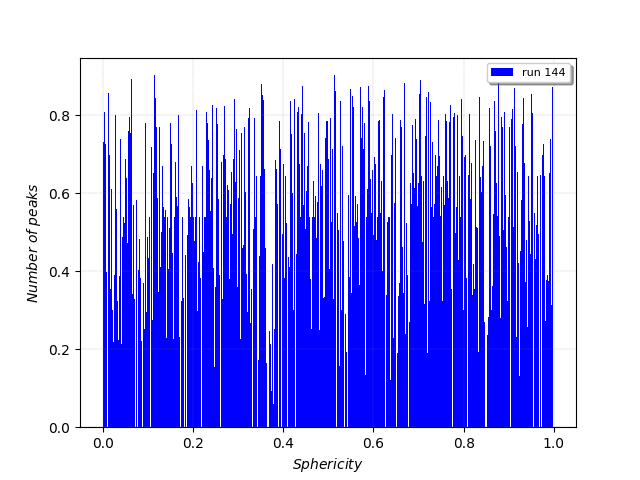

In [32]:
plt.figure()
sp_144 = []
p = run_list['r0144']['peaks']
for p_i in np.arange(len(p)):
    p_sub = p[p_i] - BG_level
    p_mask = p_sub > photon_threshold
    fill_holes = binary_fill_holes(p_mask)
    contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if perimeter != 0:
            sphericity = 4*np.pi*area/(perimeter**2)     
                #cnt_string = 'Numbers of contours for peak {} : {}, sphericity: {}'
                #print(cnt_string.format(p_i, len(contours), sphericity))
            sp_144.append(sphericity)
binwidth = 1.0/len(sp_144)
binedges = np.arange(0-binwidth/2,1.0+binwidth/2,binwidth)
yhist, bin_edges = np.histogram(sp_144, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(sp_144))])
plt.bar(bin_centers, sp_144,  color='b', width=binwidth, label = 'run 144')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

<IPython.core.display.Javascript object>


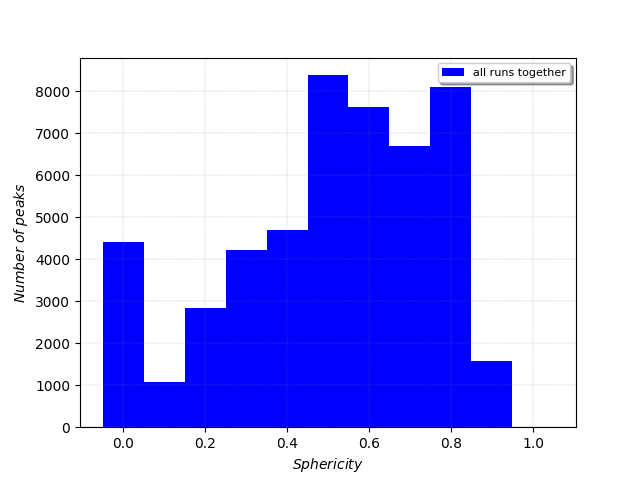

In [33]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.1
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
yhist, bin_edges = np.histogram(S_p, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
plt.bar(bin_centers, yhist,  color='b', width=binwidth, label = 'all runs together')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [34]:
bin_edges, bin_centers, yhist

(array([-0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,
         0.85,  0.95,  1.05]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([4413, 1074, 2851, 4211, 4709, 8385, 7628, 6707, 8113, 1583,    0]))

<IPython.core.display.Javascript object>


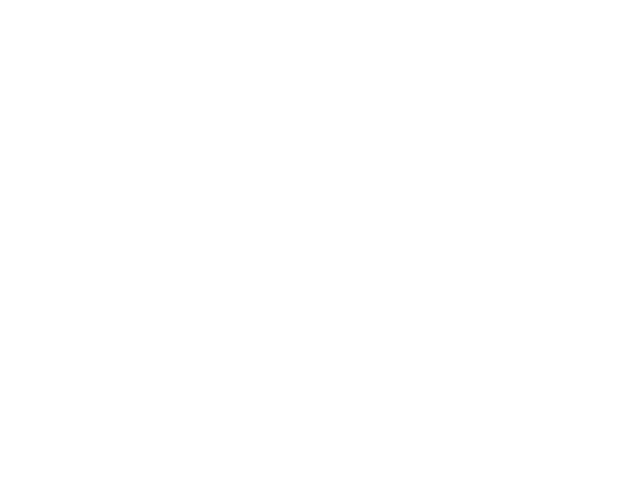

IndexError: index 22 is out of bounds for axis 0 with size 22

In [115]:
plt.figure()
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
plt.bar(bin_centers, short_all_dist('r0144')[0],  color='b', width=binwidth, label = 'all distances, all shots, r0144')
plt.bar(bin_centers, short_all_dist('r0144')[1], color='r', width=binwidth, label = 'min distances, all shots, r0144')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [36]:
all_distance = np.zeros((14,811))
min_distance = np.zeros((14,811))
for i,n in enumerate(run_list.keys()):
    all_d, min_d,_ = short_all_dist(n)
    all_distance[i] = all_d
    min_distance[i] = min_d

In [37]:
# warm temperatures runs 144 to 170
all_T_w = np.zeros((7,811))
min_T_w = np.zeros((7,811))
for i,n in enumerate(T_w):
    all_d_T_w, min_d_T_w,_ = short_all_dist(n)
    all_T_w[i] = all_d_T_w
    min_T_w[i] = min_d_T_w

In [38]:
# medium temperatures runs 167 to 173
all_T_m = np.zeros((5,811))
min_T_m = np.zeros((5,811))
for i,n in enumerate(T_m):
    all_d_T_m, min_d_T_m,_ = short_all_dist(n)
    all_T_m[i] = all_d_T_m
    min_T_m[i] = min_d_T_m

In [39]:
# cold temperatures runs 165 to 166
all_T_c = np.zeros((2,811))
min_T_c = np.zeros((2,811))
for i,n in enumerate(T_c):
    all_d_T_c, min_d_T_c,_ = short_all_dist(n)
    all_T_c[i] = all_d_T_c
    min_T_c[i] = min_d_T_c

In [40]:
# binsize = 0.1 or 0.2
def downsample(x, y, size=int(2)):
    assert (len(x) == len(y))
    if (len(x)%size != 0):
        print('WARNING: size of %d in input arrays are not dividable with %d, remainder: %d' % (len(x), size, len(x)%size))
    n = np.int(np.ceil(len(x)/size))
    new_x = np.zeros(n)
    new_y = np.zeros(n)
    for i in range(n):
        new_x[i] = np.average(x[i*size:(i+1)*size])
        new_y[i] = np.sum(y[i*size:(i+1)*size])
    return new_x, new_y


In [312]:
#new_bins[16]-binwidth*5, new_bins[18]+binwidth*5, sum_min_dists[16:18], sum_all_dists[16:18]

<IPython.core.display.Javascript object>


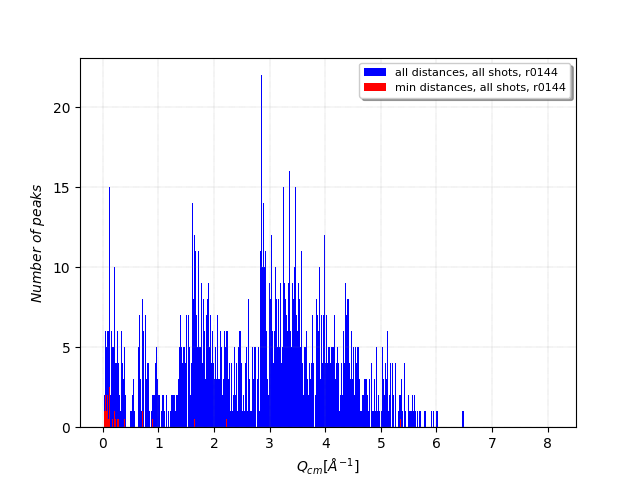

In [116]:
plt.figure()
binwidth = 0.01
hist_tot = np.zeros((811))
hist_min_tot = np.zeros((811))
binedges = np.arange(0-binwidth/2,8.1+binwidth/2,binwidth)
run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/r0144_type1-peaks_with_q.h5'
run_144 = h5py.File(run_path,'r')
shots = [x for x in run_144['shots'].keys()]
for shot_n,each_shot in enumerate(shots):
    n_peaks = run_144['shots'][each_shot]['numberOfPeaks'][()]
    try:
        qcm_x = run_144['shots'][each_shot]['peakCenterOfMassQx'][()]
        qcm_y = run_144['shots'][each_shot]['peakCenterOfMassQy'][()]
    except:
        pass   
    q_cm = list(zip(qcm_x,qcm_y))
    d = distance.cdist(q_cm,q_cm)
    all_dist = [d[np.nonzero(d)]]
    distances = np.array(all_dist).flatten()
    try:
        min_dist = [np.min(d[np.nonzero(d)])]
    except:
        pass
    min_distances = np.array(min_dist).flatten()
    yhist, bin_edges = np.histogram(distances, bins=binedges)
    minhist, bin_edges = np.histogram(min_distances, bins=binedges)
    yhist = yhist/2
    minhist = minhist/2
    hist_tot += yhist
    hist_min_tot += minhist
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
plt.bar(bin_centers, hist_tot,  color='b', width=binwidth, label = 'all distances, all shots, r0144')
plt.bar(bin_centers, hist_min_tot, color='r', width=binwidth, label = 'min distances, all shots, r0144')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

<IPython.core.display.Javascript object>


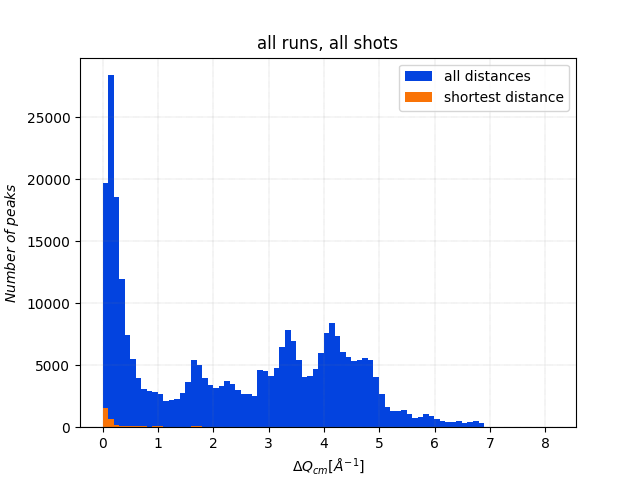

In [44]:
# peak numbers vs q_cm
plt.figure()
binwidth = 0.01
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
for i,run in enumerate(run_list.keys()):
    new_bins, new_all_dists = downsample(bin_centers, all_distance[i], size=10)
    new_bins, new_min_dists = downsample(bin_centers, min_distance[i], size=10)
    if i == 0:
        sum_all_dists = new_all_dists
        sum_min_dists = new_min_dists
    else:
        sum_all_dists += new_all_dists
        sum_min_dists += new_min_dists
    #plt.bar(bin_centers, all_distance[i],  color='#0343DF', width=binwidth)
    #plt.bar(bin_centers, min_distance[i], color='#F97306', width=binwidth)
plt.bar(new_bins, sum_all_dists,  color='#0343DF', width=binwidth*10)
plt.bar(new_bins, sum_min_dists, color='#F97306', width=binwidth*10)
plt.legend(['all distances','shortest distance'])
plt.title('all runs, all shots', loc='center')
plt.xlabel('$\Delta Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


<IPython.core.display.Javascript object>


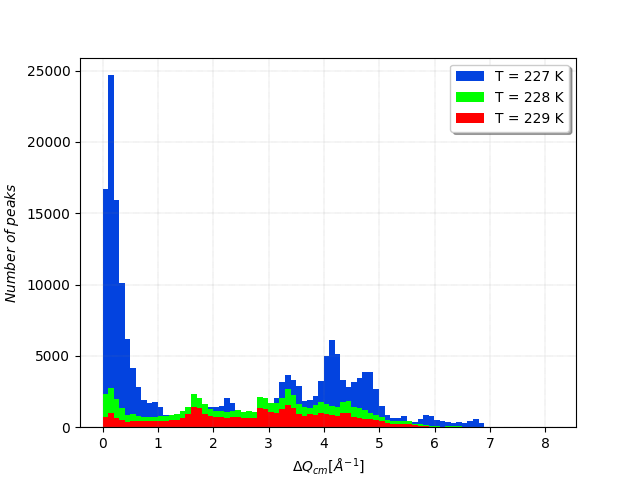

In [45]:
# peak numbers vs q_cm for the warm temperatures
plt.figure()
binwidth = 0.01
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
for i,run in enumerate(T_w):
    new_bins, new_T_w_dists = downsample(bin_centers, all_T_w[i], size=10)
    new_bins, new_min_T_w = downsample(bin_centers, min_T_w[i], size=10)
    if i == 0:
        sum_T_w_dists = new_T_w_dists
        sum_min_T_w = new_min_T_w
    else:
        sum_T_w_dists += new_T_w_dists
        sum_min_T_w += new_min_T_w
        
for i,run in enumerate(T_m):
    new_bins, new_T_m_dists = downsample(bin_centers, all_T_m[i], size=10)
    new_bins, new_min_T_m = downsample(bin_centers, min_T_m[i], size=10)
    if i == 0:
        sum_T_m_dists = new_T_m_dists
        sum_min_T_m = new_min_T_m
    else:
        sum_T_m_dists += new_T_m_dists
        sum_min_T_m += new_min_T_m
        
for i,run in enumerate(T_c):
    new_bins, new_T_c_dists = downsample(bin_centers, all_T_c[i], size=10)
    new_bins, new_min_T_c = downsample(bin_centers, min_T_c[i], size=10)
    if i == 0:
        sum_T_c_dists = new_T_c_dists
        sum_min_T_c = new_min_T_c
    else:
        sum_T_c_dists += new_T_c_dists
        sum_min_T_c += new_min_T_c
        

    #plt.bar(bin_centers, all_distance[i],  color='#0343DF', width=binwidth)
    #plt.bar(bin_centers, min_distance[i], color='#F97306', width=binwidth)
plt.bar(new_bins, sum_T_c_dists, color='#0343DF', width=binwidth*10, label = 'T = 227 K')
plt.bar(new_bins, sum_T_m_dists, color='#00FF00', width=binwidth*10, label = 'T = 228 K')
plt.bar(new_bins, sum_T_w_dists,  color='r', width=binwidth*10, label = 'T = 229 K')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$\Delta Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


<IPython.core.display.Javascript object>


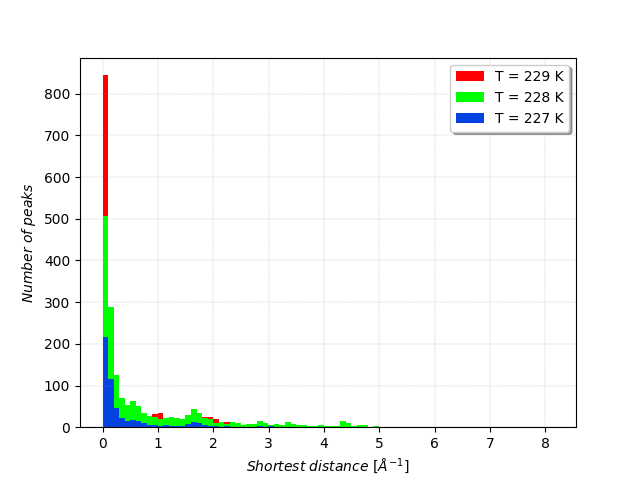

In [46]:
plt.figure()
plt.bar(new_bins, sum_min_T_c,  color='r', width=binwidth*10, label = 'T = 229 K')
plt.bar(new_bins, sum_min_T_m, color='#00FF00', width=binwidth*10, label = 'T = 228 K')
plt.bar(new_bins, sum_min_T_w, color='#0343DF', width=binwidth*10, label = 'T = 227 K')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$Shortest\ distance\ [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


In [47]:
x = run_144['shots']['LCLS_2011_Feb28_r0144_163006_2feb_cspad']['peakCenterOfMassQx'][()]

In [48]:
y = run_144['shots']['LCLS_2011_Feb28_r0144_163006_2feb_cspad']['peakCenterOfMassQy'][()]

In [49]:
list(zip(x,y))

[(0.4129202616777565, -1.8791951968943919),
 (-0.1061886510865614, -1.7555068730843517),
 (-1.5011566055745893, -1.1997693692428788),
 (1.3349837223396062, -1.0429577522031999),
 (1.388212469801472, -1.0723652294081458),
 (-1.5117902525081894, -0.603837080807235),
 (-1.4534390318401775, 0.7423097255451431),
 (1.4034058846930053, 0.8601034558833442),
 (1.4400538365956388, 0.9560856872426438),
 (1.3962670055270654, 1.051083661773669),
 (-0.005267040374824249, 1.6958082694231058)]

In [50]:
window1 = []
for i,n in enumerate(T_w):
    _, _, w = short_all_dist(n, lower_bound = 1.6 , upper_bound = 1.8 )
    window1.append(w)

In [51]:
window2 = []
for i,n in enumerate(T_m):
    _, _, w = short_all_dist(n, lower_bound = 1.6 , upper_bound = 1.8 )
    window2.append(w)

In [52]:
window3 = []
for i,n in enumerate(T_c):
    _, _, w = short_all_dist(n, lower_bound = 1.6 , upper_bound = 1.8 )
    window3.append(w)

In [54]:
def specific_shots(run, shot, path=None):
    '''
    open specific shots in a run and load its keys,
    '''
    if path is None:
        h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    else:
        h5path = path+'%s_type1-peaks.h5'%run
    h5file = h5py.File(h5path,'r')
    n_peaks = h5file['shots'][shot]['numberOfPeaks'][()]
    peak_list = []
    center_mass = []
    radius = []
    q_cm = []
    for i,j in enumerate(shot):
        try:
            peak_list.append(h5file['shots'][shot]['peak%d'%i]['diffraction'][:])
            center_mass.append(h5file['shots'][shot]['peak%d'%i]['centerOfMassInPixels'][:])
            radius.append(h5file['shots'][shot]['peak%d'%i]['radiusInPixels'][()])
            q_cm.append(h5file['shots'][shot]['peak%d'%i]['peakCenterOfMassQMagnitude'][:])
        except:
            pass
    h5file.close()
    return  {'peaks': peak_list,
             'center_mass': center_mass,
             'q_cm': q_cm,
             'No_of_peaks': n_peaks,
             'radiusInPixels': radius}

In [55]:
below50ADUs = {}
for n in files.keys():
    paths = 'below50ADUs_%s_common_shots.txt'%n
    with open(paths) as f:
        below50ADUs[n] = set([re.sub('-angavg.h5','',fname) for fname in set([fname.strip('\n') for fname in f.readlines()])])

In [56]:
below50ADUs['r0144']

{'LCLS_2011_Feb28_r0144_163103_7f8f_cspad',
 'LCLS_2011_Feb28_r0144_163149_c0f9_cspad',
 'LCLS_2011_Feb28_r0144_163414_18c1b_cspad',
 'LCLS_2011_Feb28_r0144_163529_1f560_cspad'}

In [57]:

for shot in below50ADUs['r0144']:
    print(shot)

LCLS_2011_Feb28_r0144_163414_18c1b_cspad
LCLS_2011_Feb28_r0144_163529_1f560_cspad
LCLS_2011_Feb28_r0144_163149_c0f9_cspad
LCLS_2011_Feb28_r0144_163103_7f8f_cspad


In [58]:
q_c_50ADUs = []
for i,run in enumerate(T_c):
    shot = list(below50ADUs[run])
    for el in shot:
         q_c_50ADUs.append(specific_shots(run, el)['q_cm'])

In [59]:
q_c_50ADUs = np.array(sorted(itertools.chain(*q_c_50ADUs))).T

In [60]:
q_m_50ADUs = []
for i,run in enumerate(T_m):
    shot = list(below50ADUs[run])
    for el in shot:
         q_m_50ADUs.append(specific_shots(run, el)['q_cm'])

In [61]:
q_m_50ADUs = np.array(sorted(itertools.chain(*q_m_50ADUs))).T

In [62]:
q_w_50ADUs = []
for i,run in enumerate(T_w):
    shot = list(below50ADUs[run])
    for el in shot:
         q_w_50ADUs.append(specific_shots(run, el)['q_cm'])

In [63]:
q_w_50ADUs = np.array(sorted(itertools.chain(*q_w_50ADUs))).T

<IPython.core.display.Javascript object>


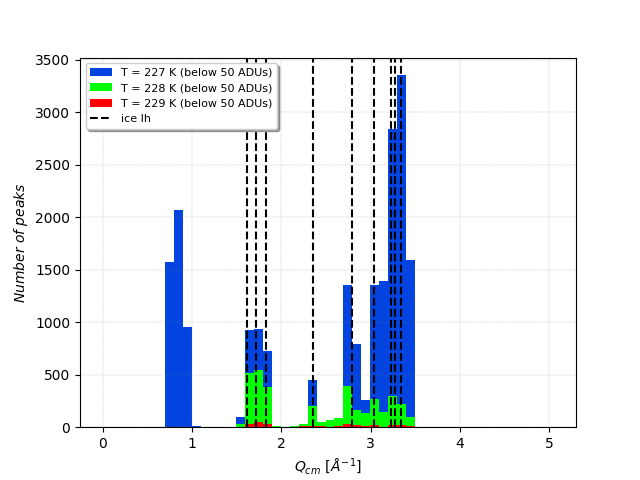

In [106]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.01
binedges = np.arange(0-binwidth/2,5.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(q_w_50ADUs, bins=binedges)
yhist_m, bin_edges_m = np.histogram(q_m_50ADUs, bins=binedges)
yhist_c, bin_edges_c = np.histogram(q_c_50ADUs, bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

T_227 = plt.bar(new_bins, new_q_cm_c,  color='#0343DF', width=binwidth*10, label= 'T = 227 K')
T_228 = plt.bar(new_bins, new_q_cm_m,  color='#00FF00', width=binwidth*10, label = 'T = 228 K')
T_229 = plt.bar(new_bins, new_q_cm_w,  color='r', width=binwidth*10, label = 'T = 229 K')
xposition = iceIh_peaks()
for xc in xposition[:-1]:
    ice_plot = plt.axvline(x=xc, color='k', linestyle='--')

plt.legend(handles=[T_227, T_228, T_229, ice_plot], labels=['T = 227 K (below 50 ADUs)', 'T = 228 K (below 50 ADUs)', 'T = 229 K (below 50 ADUs)', 'ice Ih'], loc='best', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q_{cm}\ [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


In [65]:
shots_below_w = {}
for i,run in enumerate(T_w):
    shots_below_w[run] = below50ADUs[run]

In [66]:
shots_below_m = {}
for i,run in enumerate(T_m):
    shots_below_m[run] = below50ADUs[run]

In [67]:
shots_below_c = {}
for i,run in enumerate(T_c):
    shots_below_c[run] = below50ADUs[run]

In [68]:
all_shots_w = {}
for i,run in enumerate(T_w):
    h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    h5file = h5py.File(h5path,'r')
    #shots = [x for x in h5file['shots'].keys()]
    all_shots_w[run] = {x for x in h5file['shots'].keys()}

In [69]:
all_shots_m = {}
for i,run in enumerate(T_m):
    h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    h5file = h5py.File(h5path,'r')
    #shots = [x for x in h5file['shots'].keys()]
    all_shots_m[run] = {x for x in h5file['shots'].keys()}

In [70]:
all_shots_c = {}
for i,run in enumerate(T_c):
    h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    h5file = h5py.File(h5path,'r')
    #shots = [x for x in h5file['shots'].keys()]
    all_shots_c[run] = {x for x in h5file['shots'].keys()}

In [71]:
above_50ADUs_w = {}
for i,run in enumerate(T_w):
    above_50ADUs_w[run] = all_shots_w[run].difference(shots_below_w[run])

In [72]:
above_50ADUs_m = {}
for i,run in enumerate(T_m):
    above_50ADUs_m[run] = all_shots_m[run].difference(shots_below_m[run])

In [73]:
above_50ADUs_c = {}
for i,run in enumerate(T_c):
    above_50ADUs_c[run] = all_shots_c[run].difference(shots_below_c[run])

In [74]:
q_w_above = []
for i,run in enumerate(T_w):
    shot = list(above_50ADUs_w[run])
    for el in shot:
         q_w_above.append(specific_shots(run, el)['q_cm'])

In [75]:
q_w_above = np.array(sorted(itertools.chain(*q_w_above))).T

In [76]:
q_m_above = []
for i,run in enumerate(T_m):
    shot = list(above_50ADUs_m[run])
    for el in shot:
         q_m_above.append(specific_shots(run, el)['q_cm'])

In [77]:
q_m_above = np.array(sorted(itertools.chain(*q_m_above))).T

In [78]:
q_c_above = []
for i,run in enumerate(T_c):
    shot = list(above_50ADUs_c[run])
    for el in shot:
         q_c_above.append(specific_shots(run, el)['q_cm'])
            
q_c_above = np.array(sorted(itertools.chain(*q_c_above))).T

<IPython.core.display.Javascript object>


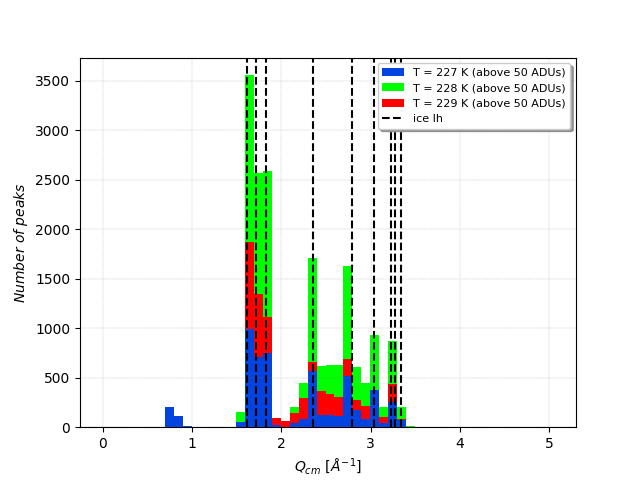

In [107]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.01
binedges = np.arange(0-binwidth/2,5.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(np.array(q_w_above), bins=binedges)
yhist_m, bin_edges_m = np.histogram(np.array(q_m_above), bins=binedges)
yhist_c, bin_edges_c = np.histogram(np.array(q_c_above), bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

T_228 = plt.bar(new_bins, new_q_cm_m,  color='#00FF00', width=binwidth*10, label = 'T = 228 K')
T_229 = plt.bar(new_bins, new_q_cm_w,  color='r', width=binwidth*10, label = 'T = 229 K')
T_227 = plt.bar(new_bins, new_q_cm_c,  color='#0343DF', width=binwidth*10, label= 'T = 227 K')
xposition = iceIh_peaks()
for xc in xposition[:-1]:
    ice_plot = plt.axvline(x=xc, color='k', linestyle='--')

plt.legend(handles=[T_227, T_228, T_229, ice_plot], labels=['T = 227 K (above 50 ADUs)', 'T = 228 K (above 50 ADUs)', 'T = 229 K (above 50 ADUs)', 'ice Ih'], loc='best', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q_{cm}\ [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  


In [470]:
def Shot_for_sp(T_group, shots, lower_bound=None, upper_bound=None):
    Dict = {}
    for n, run in enumerate(T_group):
        Dict[run] = {}
        for shot in shots[run]:
            Dict[run][shot] = {}
            p_n = specific_shots(run, shot)['peaks']
            for peak_i in np.arange(len(p_n)):
                Dict[run][shot]['peak%s'%peak_i] = {}
                #Dict[run][shot]['peak%s'%peak_i] = p_n[peak_i]
                p_sub = p_n[peak_i] - BG_level
                p_mask = p_sub > photon_threshold
                fill_holes = binary_fill_holes(p_mask)
                contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                for cn, cnt in enumerate(contours):
                    Dict[run][shot]['peak%s'%peak_i][cn] = {}
                    perimeter = cv2.arcLength(cnt, True)
                    area = cv2.contourArea(cnt)
                    if perimeter != 0:
                        sphericity = 4*np.pi*area/(perimeter**2)
                        if (lower_bound is not None) and (upper_bound is not None):
                            if np.any((sphericity >= lower_bound) & (sphericity < upper_bound)):
                                Dict[run][shot]['peak%s'%peak_i][cn] = (p_n[peak_i],sphericity)
                        else:
                            Dict[run][shot]['peak%s'%peak_i][cn] = (p_n[peak_i],sphericity)
    return Dict


In [547]:
choice = 'small_peaks'
#Dict = []
p_sub = peak_diff - BG_level
p_mask = p_sub > photon_threshold
fill_holes = binary_fill_holes(p_mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
for p,i in enumerate(peak_regions):
    if (choice == 'large_peaks') & (np.shape(fill_holes[i]) >= (3,3)):
        contour,_= cv2.findContours(fill_holes[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for t in range(len(contour)):
            perimeter = cv2.arcLength(contour[t], True)
            area = cv2.contourArea(contour[t])
            if perimeter != 0:
                sphericity = 4*np.pi*area/(perimeter**2)
                print(t)
                #print(sphericity)
    elif (choice == 'small_peaks') & (np.shape(fill_holes[i]) < (3,3)):
        contour,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        perimeter = np.array([cv2.arcLength(contour[t], True) for t in range(len(contour))])
        area = np.array([cv2.contourArea(contour[t]) for t in range(len(contour))])
        sphericity = 4*np.pi*area/(perimeter**2)
        print(sphericity[])

IndexError: too many indices for array

In [552]:
def Shot_for_sp(T_group, shots, size_thr = (10,10), choice = 'large_peaks', lower_bound=None, upper_bound=None):
    Dict = {}
    for n, run in enumerate(T_group):
        Dict[run] = {}
        for shot in shots[run]:
            Dict[run][shot] = {}
            p_n = specific_shots(run, shot)['peaks']
            for peak_i in np.arange(len(p_n)):
                Dict[run][shot]['peak%s'%peak_i] = {}
                #Dict[run][shot]['peak%s'%peak_i] = p_n[peak_i]
                p_sub = p_n[peak_i] - BG_level
                p_mask = p_sub > photon_threshold
                fill_holes = binary_fill_holes(p_mask)
                labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
                peak_regions = scipy.ndimage.find_objects(labeled_image)
                for p,i in enumerate(peak_regions):
                    if (choice == 'large_peaks') & (np.shape(fill_holes[i]) >= size_thr):
                        contour,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                        perimeter = np.array([cv2.arcLength(contour[t], True) for t in range(len(contour))])
                        area = np.array([cv2.contourArea(contour[t]) for t in range(len(contour))])
                        if perimeter.any()!= 0:
                            sphericity = 4*np.pi*area/(perimeter**2)
                            for s in range(len(sphericity)):
                                Dict[run][shot]['peak%s'%peak_i]['contour%s'%s] = {}
                                if (lower_bound is not None) and (upper_bound is not None):
                                    if np.any((sphericity >= lower_bound) & (sphericity < upper_bound)):
                                        Dict[run][shot]['peak%s'%peak_i]['contour%s'%s] = (p_n[peak_i][i],sphericity[s])
                                else:
                                    Dict[run][shot]['peak%s'%peak_i]['contour%s'%s] = (p_n[peak_i][i],sphericity[s])
                    elif (choice == 'small_peaks') & (np.shape(fill_holes[i]) <= size_thr):
                        contour,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                        perimeter = np.array([cv2.arcLength(contour[t], True) for t in range(len(contour))])
                        area = np.array([cv2.contourArea(contour[t]) for t in range(len(contour))])
                        if perimeter.any()!= 0:
                            sphericity = 4*np.pi*area/(perimeter**2)
                            for s in range(len(sphericity)):
                                Dict[run][shot]['peak%s'%peak_i]['contour%s'%s] = {}
                                if (lower_bound is not None) and (upper_bound is not None):
                                    if np.any((sphericity >= lower_bound) & (sphericity < upper_bound)):
                                        Dict[run][shot]['peak%s'%peak_i]['contour%s'%s] = (p_n[peak_i][i],sphericity[s])
                                else:
                                    Dict[run][shot]['peak%s'%peak_i]['contour%s'%s] = (p_n[peak_i][i],sphericity[s])
                        
    return Dict

In [81]:
s_m_above = []
for n, run in enumerate(T_m):
    for shot in above_50ADUs_m[run]:
        p_n = specific_shots(run, shot)['peaks']
        for peak_i in np.arange(len(p_n)):
            p_sub = p_n[peak_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    s_m_above.append(sphericity)

In [82]:
s_c_above = []
for n, run in enumerate(T_c):
    for shot in above_50ADUs_c[run]:
        p_n = specific_shots(run, shot)['peaks']
        for peak_i in np.arange(len(p_n)):
            p_sub = p_n[peak_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    s_c_above.append(sphericity)

In [83]:
s_w_above = []
for n, run in enumerate(T_w):
    for shot in above_50ADUs_w[run]:
        p_n = specific_shots(run, shot)['peaks']
        for peak_i in np.arange(len(p_n)):
            p_sub = p_n[peak_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    s_w_above.append(sphericity)

In [84]:
s_w_below = []
for n, run in enumerate(T_w):
    for shot in shots_below_w[run]:
        p_n = specific_shots(run, shot)['peaks']
        for peak_i in np.arange(len(p_n)):
            p_sub = p_n[peak_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    s_w_below.append(sphericity)

In [85]:
s_m_below = []
for n, run in enumerate(T_m):
    for shot in shots_below_m[run]:
        p_n = specific_shots(run, shot)['peaks']
        for peak_i in np.arange(len(p_n)):
            p_sub = p_n[peak_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    s_m_below.append(sphericity)

In [86]:
s_c_below = []
for n, run in enumerate(T_c):
    for shot in shots_below_c[run]:
        p_n = specific_shots(run, shot)['peaks']
        for peak_i in np.arange(len(p_n)):
            p_sub = p_n[peak_i] - BG_level
            p_mask = p_sub > photon_threshold
            fill_holes = binary_fill_holes(p_mask)
            contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for cnt in contours:
                perimeter = cv2.arcLength(cnt, True)
                area = cv2.contourArea(cnt)
                if perimeter != 0:
                    sphericity = 4*np.pi*area/(perimeter**2)
                    s_c_below.append(sphericity)

<IPython.core.display.Javascript object>


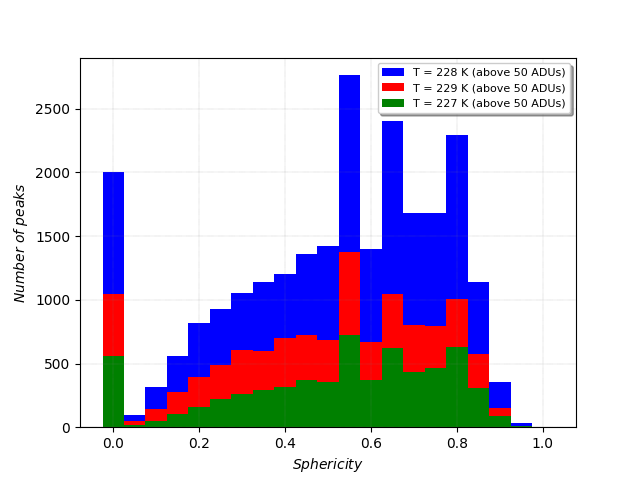

In [87]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(s_w_above, bins=binedges)
Sp_m, bin_edges = np.histogram(s_m_above, bins=binedges)
Sp_c, bin_edges = np.histogram(s_c_above, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K (above 50 ADUs)')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K (above 50 ADUs)')
plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K (above 50 ADUs)')

plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

<IPython.core.display.Javascript object>


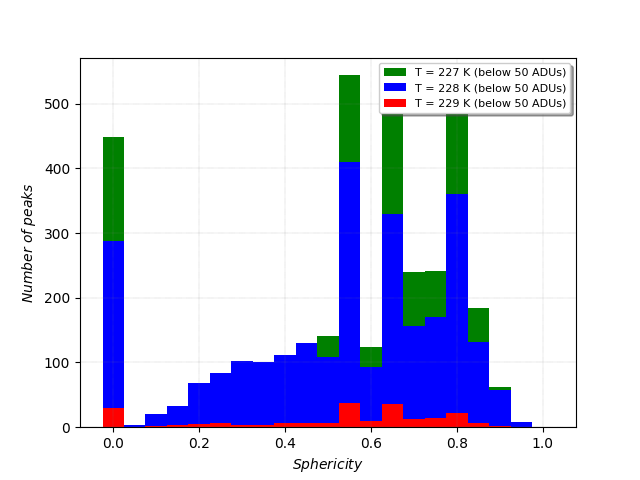

In [88]:
plt.figure()
#binwidth = 1.0/len(S_p)
binwidth = 0.05
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
Sp_w, bin_edges = np.histogram(s_w_below, bins=binedges)
Sp_m, bin_edges = np.histogram(s_m_below, bins=binedges)
Sp_c, bin_edges = np.histogram(s_c_below, bins=binedges)
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

plt.bar(bin_centers, Sp_c,  color='g', width=binwidth, label = 'T = 227 K (below 50 ADUs)')
plt.bar(bin_centers, Sp_m,  color='b', width=binwidth, label = 'T = 228 K (below 50 ADUs)')
plt.bar(bin_centers, Sp_w,  color='r', width=binwidth, label = 'T = 229 K (below 50 ADUs)')
plt.legend(loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()

In [89]:
def short_all_dist(run, binwidth=0.01, lower_bound=None, upper_bound=None):
    '''
    returns all distances in each shots for one run and also the minimum 
    distance among all distances for a shot
    
    '''
    hist_tot = np.zeros((811))
    hist_min_tot = np.zeros((811))
    binedges = np.arange(0-binwidth/2,8.1+binwidth/2,binwidth)
    run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    run_no = h5py.File(run_path,'r')
    shots = [x for x in run_no['shots'].keys()]
    if (lower_bound is not None) and (upper_bound is not None):
        shots_in_bounds = []
    else:
        shots_in_bounds = None
    for shot_n,each_shot in enumerate(shots):
        n_peaks = run_no['shots'][each_shot]['numberOfPeaks'][()]
        try:
            qcm_x = run_no['shots'][each_shot]['peakCenterOfMassQx'][()]
            qcm_y = run_no['shots'][each_shot]['peakCenterOfMassQy'][()]
        except:
            pass
        q_cm = list(zip(qcm_x,qcm_y))
        d = distance.cdist(q_cm,q_cm)
        all_dist = [d[np.nonzero(d)]]
        distances = np.array(all_dist).flatten()
        if (lower_bound is not None) and (upper_bound is not None):
            if np.any((distances >= lower_bound) & (distances < upper_bound)):
                shots_in_bounds.append(each_shot)
        try:
            min_dist = [np.min(d[np.nonzero(d)])]
        except:
            pass
        min_distances = np.array(min_dist).flatten()
        yhist, bin_edges = np.histogram(distances, bins=binedges)
        minhist, bin_edges = np.histogram(min_distances, bins=binedges)
        yhist = yhist/2
        minhist = minhist/2
        hist_tot += yhist
        hist_min_tot += minhist
    return hist_tot, hist_min_tot, shots_in_bounds

In [90]:
def dist_for_shot(run, shots, binwidth=0.01, lower_bound=None, upper_bound=None):
    '''
    returns all distances in each shots for one run and also the minimum 
    distance among all distances for a shot
    '''
    hist_tot = np.zeros((811))
    hist_min_tot = np.zeros((811))
    binedges = np.arange(0-binwidth/2,8.1+binwidth/2,binwidth)
    run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    run_no = h5py.File(run_path,'r')
    if (lower_bound is not None) and (upper_bound is not None):
        shots_in_bounds = []
    else:
        shots_in_bounds = None
    for shot_n,each_shot in enumerate(list(shots[run])):
        n_peaks = run_no['shots'][each_shot]['numberOfPeaks'][()]
        if n_peaks >= 1:
            qcm_x = run_no['shots'][each_shot]['peakCenterOfMassQx'][()]
            qcm_y = run_no['shots'][each_shot]['peakCenterOfMassQy'][()]
            q_cm = list(zip(qcm_x,qcm_y))
            d = distance.cdist(q_cm,q_cm)
            all_dist = [d[np.nonzero(d)]]
            distances = np.array(all_dist).flatten()
            if (lower_bound is not None) and (upper_bound is not None):
                if np.any((distances >= lower_bound) & (distances < upper_bound)):
                    shots_in_bounds.append(each_shot)
            try:
                min_dist = [np.min(d[np.nonzero(d)])]
                min_distances = np.array(min_dist).flatten()
                yhist, bin_edges = np.histogram(distances, bins=binedges)
                minhist, bin_edges = np.histogram(min_distances, bins=binedges)
                yhist = yhist/2
                minhist = minhist/2
                hist_tot += yhist
                hist_min_tot += minhist
            except:
                pass
    return hist_tot, hist_min_tot, shots_in_bounds

In [91]:
# warm temperatures runs 144 to 170
d_w_below = np.zeros((7,811))
min_dw_below = np.zeros((7,811))
for i,n in enumerate(T_w):
    T_w_below, min_Tw_below, _ = dist_for_shot(n, shots_below_w)
    d_w_below[i] = T_w_below
    min_dw_below[i] = min_Tw_below

In [92]:
d_m_below = np.zeros((5,811))
min_dm_below = np.zeros((5,811))
for i,n in enumerate(T_m):
    T_m_below, min_Tm_below, _ = dist_for_shot(n, shots_below_m)
    d_m_below[i] = T_m_below
    min_dm_below[i] = min_Tm_below

In [93]:
d_c_below = np.zeros((2,811))
min_dc_below = np.zeros((2,811))
for i,n in enumerate(T_c):
    T_c_below, min_Tc_below, _ = dist_for_shot(n, shots_below_c)
    d_c_below[i] = T_c_below
    min_dc_below[i] = min_Tc_below

<IPython.core.display.Javascript object>


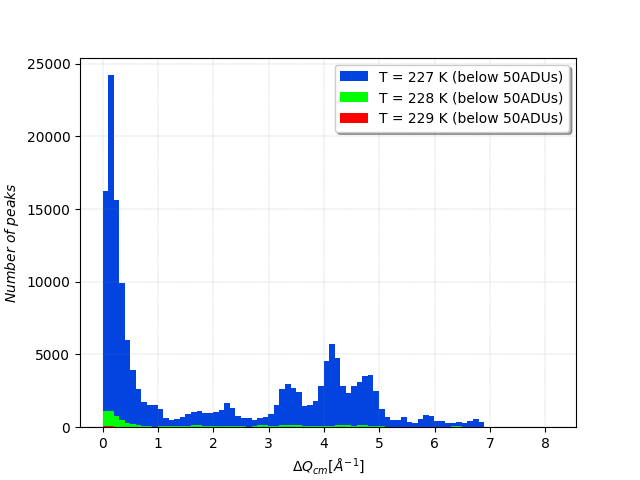

In [117]:
plt.figure()
binwidth = 0.01
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
for i,run in enumerate(T_w):
    new_bins, new_T_w_dists = downsample(bin_centers, d_w_below[i], size=10)
    new_bins, new_min_T_w = downsample(bin_centers, min_dw_below[i], size=10)
    if i == 0:
        sum_T_w_dists = new_T_w_dists
        sum_min_T_w = new_min_T_w
    else:
        sum_T_w_dists += new_T_w_dists
        sum_min_T_w += new_min_T_w
        
for i,run in enumerate(T_m):
    new_bins, new_T_m_dists = downsample(bin_centers, d_m_below[i], size=10)
    new_bins, new_min_T_m = downsample(bin_centers, min_dm_below[i], size=10)
    if i == 0:
        sum_T_m_dists = new_T_m_dists
        sum_min_T_m = new_min_T_m
    else:
        sum_T_m_dists += new_T_m_dists
        sum_min_T_m += new_min_T_m
        
for i,run in enumerate(T_c):
    new_bins, new_T_c_dists = downsample(bin_centers, d_c_below[i], size=10)
    new_bins, new_min_T_c = downsample(bin_centers, min_dc_below[i], size=10)
    if i == 0:
        sum_T_c_dists = new_T_c_dists
        sum_min_T_c = new_min_T_c
    else:
        sum_T_c_dists += new_T_c_dists
        sum_min_T_c += new_min_T_c
        

    #plt.bar(bin_centers, all_distance[i],  color='#0343DF', width=binwidth)
    #plt.bar(bin_centers, min_distance[i], color='#F97306', width=binwidth)
plt.bar(new_bins, sum_T_c_dists, color='#0343DF', width=binwidth*10, label = 'T = 227 K (below 50ADUs)')
plt.bar(new_bins, sum_T_m_dists, color='#00FF00', width=binwidth*10, label = 'T = 228 K (below 50ADUs)')
plt.bar(new_bins, sum_T_w_dists,  color='r', width=binwidth*10, label = 'T = 229 K (below 50ADUs)')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$\Delta Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  

<IPython.core.display.Javascript object>


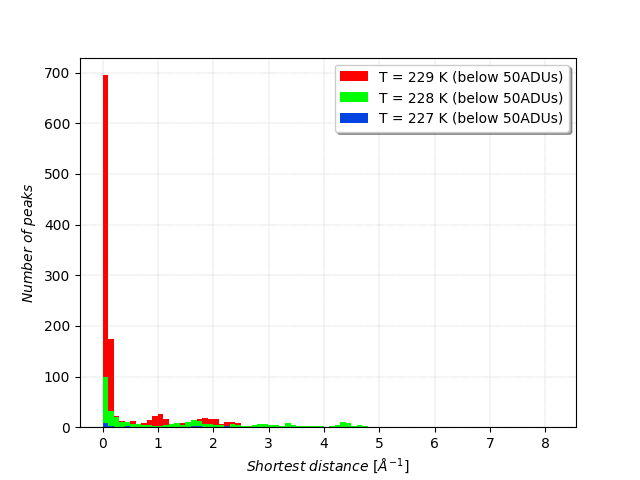

In [118]:
plt.figure()
plt.bar(new_bins, sum_min_T_c,  color='r', width=binwidth*10, label = 'T = 229 K (below 50ADUs)')
plt.bar(new_bins, sum_min_T_m, color='#00FF00', width=binwidth*10, label = 'T = 228 K (below 50ADUs)')
plt.bar(new_bins, sum_min_T_w, color='#0343DF', width=binwidth*10, label = 'T = 227 K (below 50ADUs)')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$Shortest\ distance\ [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  

In [97]:
# third one should be shot numbers
# the second one is peak numbers
len(shots_below_c['r0165']), sum(d_c_below[0]), sum(min_dc_below[0])


(2402, 166788.0, 1147.0)

In [98]:
# warm temperatures runs 144 to 170
d_w_above = np.zeros((7,811))
min_dw_above = np.zeros((7,811))
for i,n in enumerate(T_w):
    T_w_above, min_Tw_above, _ = dist_for_shot(n, above_50ADUs_w)
    d_w_above[i] = T_w_above
    min_dw_above[i] = min_Tw_above

In [99]:
d_m_above = np.zeros((5,811))
min_dm_above = np.zeros((5,811))
for i,n in enumerate(T_m):
    T_m_above, min_Tm_above, _ = dist_for_shot(n, above_50ADUs_m)
    d_m_above[i] = T_m_above
    min_dm_above[i] = min_Tm_above

In [100]:
d_c_above = np.zeros((2,811))
min_dc_above = np.zeros((2,811))
for i,n in enumerate(T_c):
    T_c_above, min_Tc_above, _ = dist_for_shot(n, above_50ADUs_c)
    d_c_above[i] = T_c_above
    min_dc_above[i] = min_Tc_above

<IPython.core.display.Javascript object>


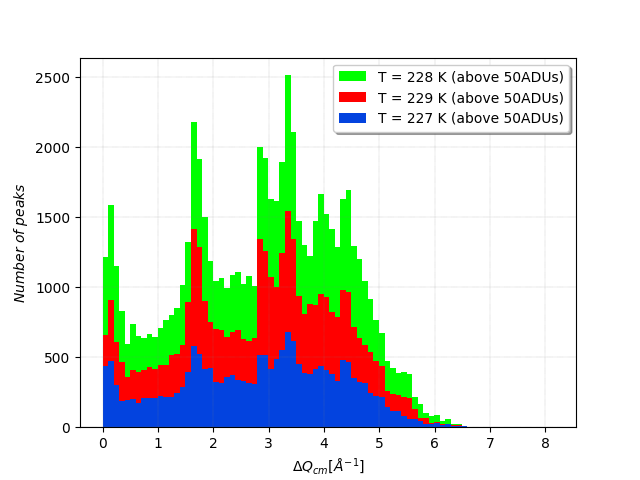

In [343]:
plt.figure()
binwidth = 0.01
bin_centers = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(hist_tot))])
for i,run in enumerate(T_w):
    new_bins, new_T_w_dists = downsample(bin_centers, d_w_above[i], size=10)
    new_bins, new_min_T_w = downsample(bin_centers, min_dw_above[i], size=10)
    if i == 0:
        sum_T_w_dists = new_T_w_dists
        sum_min_T_w = new_min_T_w
    else:
        sum_T_w_dists += new_T_w_dists
        sum_min_T_w += new_min_T_w
        
for i,run in enumerate(T_m):
    new_bins, new_T_m_dists = downsample(bin_centers, d_m_above[i], size=10)
    new_bins, new_min_T_m = downsample(bin_centers, min_dm_above[i], size=10)
    if i == 0:
        sum_T_m_dists = new_T_m_dists
        sum_min_T_m = new_min_T_m
    else:
        sum_T_m_dists += new_T_m_dists
        sum_min_T_m += new_min_T_m
        
for i,run in enumerate(T_c):
    new_bins, new_T_c_dists = downsample(bin_centers, d_c_above[i], size=10)
    new_bins, new_min_T_c = downsample(bin_centers, min_dc_above[i], size=10)
    if i == 0:
        sum_T_c_dists = new_T_c_dists
        sum_min_T_c = new_min_T_c
    else:
        sum_T_c_dists += new_T_c_dists
        sum_min_T_c += new_min_T_c
        

    #plt.bar(bin_centers, all_distance[i],  color='#0343DF', width=binwidth)
    #plt.bar(bin_centers, min_distance[i], color='#F97306', width=binwidth)
plt.bar(new_bins, sum_T_m_dists, color='#00FF00', width=binwidth*10, label = 'T = 228 K (above 50ADUs)')
plt.bar(new_bins, sum_T_w_dists,  color='r', width=binwidth*10, label = 'T = 229 K (above 50ADUs)')
plt.bar(new_bins, sum_T_c_dists, color='#0343DF', width=binwidth*10, label = 'T = 227 K (above 50ADUs)')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$\Delta Q_{cm} [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show()  

<IPython.core.display.Javascript object>


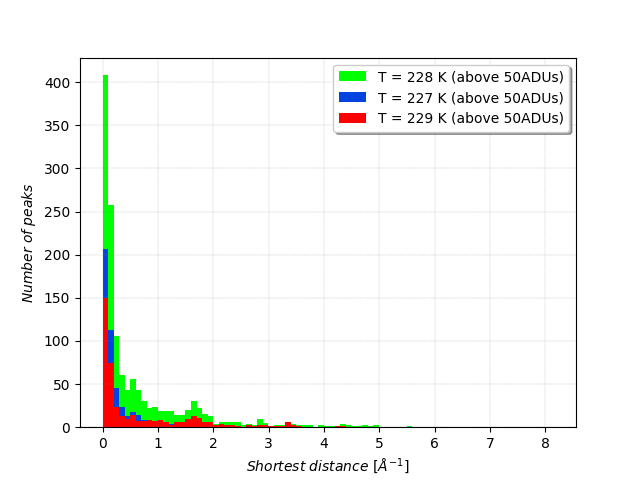

In [120]:
plt.figure()
plt.bar(new_bins, sum_min_T_m, color='#00FF00', width=binwidth*10, label = 'T = 228 K (above 50ADUs)')
plt.bar(new_bins, sum_min_T_w, color='#0343DF', width=binwidth*10, label = 'T = 227 K (above 50ADUs)')
plt.bar(new_bins, sum_min_T_c,  color='r', width=binwidth*10, label = 'T = 229 K (above 50ADUs)')

plt.legend(loc='upper right', prop={'size': 10}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
#plt.title('all runs, all shots', loc='center')
plt.xlabel('$Shortest\ distance\ [\AA^{-1}]$')
plt.ylabel('$Number$ $of$ $peaks$')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.show() 

In [103]:
_,_, peak_1 = dist_for_shot('r0171', above_50ADUs_m, lower_bound=4.3, upper_bound=4.4)

In [126]:
dd = dist_one_shot('r0144','LCLS_2011_Feb28_r0144_163006_2feb_cspad')[0][0][3]

In [500]:
peak_diff = Shot_for_sp(T_m, above_50ADUs_m)['r0167']['LCLS_2011_Mar01_r0167_002412_7b2d_cspad']['peak0'][0][0]
sphericity = []
p_sub = peak_diff - BG_level
p_mask = p_sub > photon_threshold
fill_holes = binary_fill_holes(p_mask)
labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
peak_regions = scipy.ndimage.find_objects(labeled_image)
contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for cnt in contours:
    perimeter = cv2.arcLength(cnt, True)
    area = cv2.contourArea(cnt)
    sphericity.append(4*np.pi*area/(perimeter**2))
    
x_con = [contours[0][i][0][0] for i in range(len(contours[0]))]
y_con = [contours[0][i][0][1] for i in range(len(contours[0]))]

x_con1= [contours[1][i][0][0] for i in range(len(contours[1]))]
y_con1= [contours[1][i][0][1] for i in range(len(contours[1]))]

x_con.append(int(contours[0][0][0][0]))
y_con.append(int(contours[0][0][0][1]))

x_con1.append(int(contours[1][0][0][0]))
y_con1.append(int(contours[1][0][0][1]))


In [484]:
np.shape(fill_holes[peak_regions[0]]), np.shape(fill_holes[peak_regions[1]]), np.shape(fill_holes[peak_regions[2]]), np.shape(fill_holes[peak_regions[3]])

((6, 3), (3, 1), (2, 2), (4, 3))

In [ ]:
peak_diff = Shot_for_sp(T_m, above_50ADUs_m)['r0167']['LCLS_2011_Mar01_r0167_002412_7b2d_cspad']['peak0'][0][0]

<IPython.core.display.Javascript object>


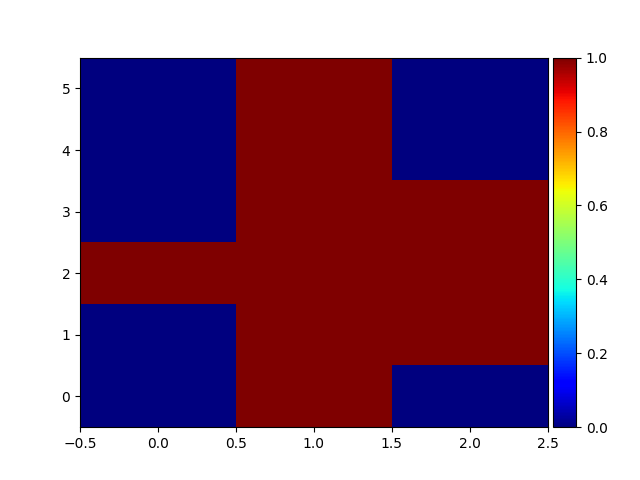

In [418]:
fig, ax = plt.subplots()
#for i in small_peaks:
ax.imshow(small_peaks[0],cmap='jet', origin = 'lower', aspect='auto')
#ax.contour(p_mask, extend='both',linewidths=2)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
#plt.clim(vmin=0,vmax=400)
plt.show()

In [372]:
#fill_holes.astype(np.float32) - np.zeros(np.shape(peak_diff), dtype=bool)

In [132]:
#x_con2 = [contours[3][i][0][0] for i in range(len(contours[3]))]
#y_con2 = [contours[3][i][0][1] for i in range(len(contours[3]))]
x_con3= [contours[2][i][0][0] for i in range(len(contours[2]))]
y_con3= [contours[2][i][0][1] for i in range(len(contours[2]))]
#x_con2.append(int(contours[3][0][0][0]))
x_con3.append(int(contours[2][0][0][0]))
#y_con2.append(int(contours[3][0][0][1]))
y_con3.append(int(contours[2][0][0][1]))

IndexError: list index out of range

In [549]:
#Shot_for_sp(T_m, above_50ADUs_m, size_thr = (10,10), choice = 'small_peaks', lower_bound=None, upper_bound=None)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [553]:
Shot_for_sp(T_m, above_50ADUs_m, choice = 'small_peaks')['r0167']['LCLS_2011_Mar01_r0167_002412_7b2d_cspad']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


{'peak0': {'contour0': (array([[2819, 2205, 1695],
          [3499, 2920, 2012],
          [3025, 3006, 2147],
          [2172, 2286, 2132]], dtype=int16), 0.6380493753606353),
  'contour1': (array([[2819, 2205, 1695],
          [3499, 2920, 2012],
          [3025, 3006, 2147],
          [2172, 2286, 2132]], dtype=int16), 0.5390120920947209),
  'contour2': (array([[2819, 2205, 1695],
          [3499, 2920, 2012],
          [3025, 3006, 2147],
          [2172, 2286, 2132]], dtype=int16), 0.0),
  'contour3': (array([[2819, 2205, 1695],
          [3499, 2920, 2012],
          [3025, 3006, 2147],
          [2172, 2286, 2132]], dtype=int16), 0.36991941864889716)},
 'peak1': {},
 'peak2': {},
 'peak3': {},
 'peak4': {'contour0': (array([[  679,  1245,  3133,  4065,  2564,  1499,  1042,   473],
          [ 1001,  3608,  8272,  8884,  6886,  4888,  5549,  2430],
          [ 1979,  8314, 11434, 11392, 11363,  9720, 10953,  7537],
          [ 4480, 11370, 11481, 11481, 11506, 11545, 11378, 10538

<IPython.core.display.Javascript object>


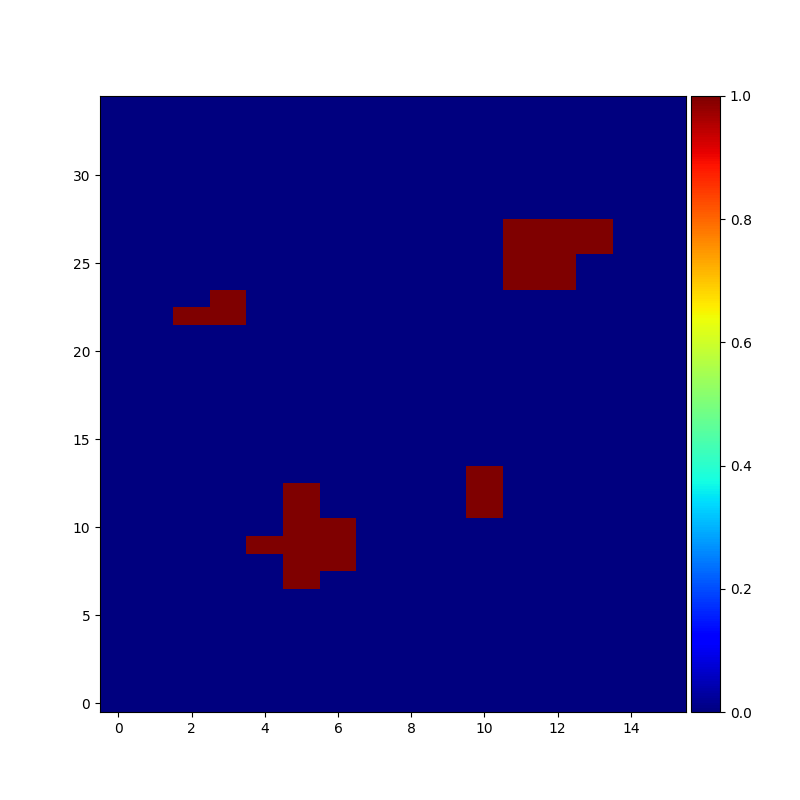

In [471]:
peak_diff = Shot_for_sp(T_m, above_50ADUs_m, upper_bound=0.57)['r0167']['LCLS_2011_Mar01_r0167_001514_185ac_cspad']['peak2'][0]
fig = plt.figure(figsize=[8,8])
ax = fig.gca()
#plt.plot(x_con, y_con, 'y-')
#plt.plot(x_con1, y_con1, 'y-')
#plt.plot(x_con2, y_con2, 'y-')
#plt.plot(x_con3, y_con3, 'y-')
#plt.text(contours[0][0][0][0]-1.5, contours[0][0][0][1]-1.5, sphericity[0], color = 'y', fontsize = 20)
#plt.text(contours[1][0][0][0]-1.5, contours[1][0][0][1]-1.5, sphericity[1], color = 'y', fontsize = 20)
#plt.text(contours[2][0][0][0]-1.5, contours[2][0][0][1]-1.5, sphericity[2], color = 'y', fontsize = 20)
#plt.text(contours[3][0][0][0]-1.5, contours[3][0][0][1]-1.5, sphericity[3], bbox=dict(color='y', linewidth=2, alpha=0.8))
im = ax.imshow(fill_holes,cmap='jet', origin = 'lower', aspect='auto')
#ax.contour(p_mask, extend='both',linewidths=2)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
#plt.clim(vmin=0,vmax=400)
plt.show()


In [583]:
textfile = open('lower_bound=0.78_upper_bound=0.82.txt', 'w')
for key, value in Shot_for_sp(T_m, above_50ADUs_m, lower_bound=0.78, upper_bound=0.82).items(): 
    textfile.write('%s:%s\n' % (key, value))
textfile.close()

In [123]:
def dist_one_shot(run, shot):
    '''
    calculate peak distances for a shot
    '''
    run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    run_no = h5py.File(run_path,'r')
    n_peaks = run_no['shots'][shot]['numberOfPeaks'][()]
    if n_peaks >= 1:
        qcm_x = run_no['shots'][shot]['peakCenterOfMassQx'][()]
        qcm_y = run_no['shots'][shot]['peakCenterOfMassQy'][()]
        centre = run_no['shots'][shot]['peakCenterOfMassInPixels'][:]
        q_cm = list(zip(qcm_x,qcm_y))
        distances = distance.cdist(q_cm,q_cm) 
        try:
            min_dist = [np.min(distances[np.nonzero(distances)])]
            min_distances = np.array(min_dist)
        except:
            pass
    return distances, min_distances, centre

In [333]:
selected_shot = dist_one_shot('r0168', 'LCLS_2011_Mar01_r0168_004818_6ca8_cspad')

# this dictionary determines which distance corresponds to which points
array_of_tuples = map(tuple, Center)
Center = list(array_of_tuples)
dict_ex = {}
for i,j in enumerate(Center):
    dict_ex[j] = {}
    for m,k in enumerate(Center):
        dict_ex[j][k] = {}
        dict_ex[j][k] = selected_shot[0][i][m]

<IPython.core.display.Javascript object>


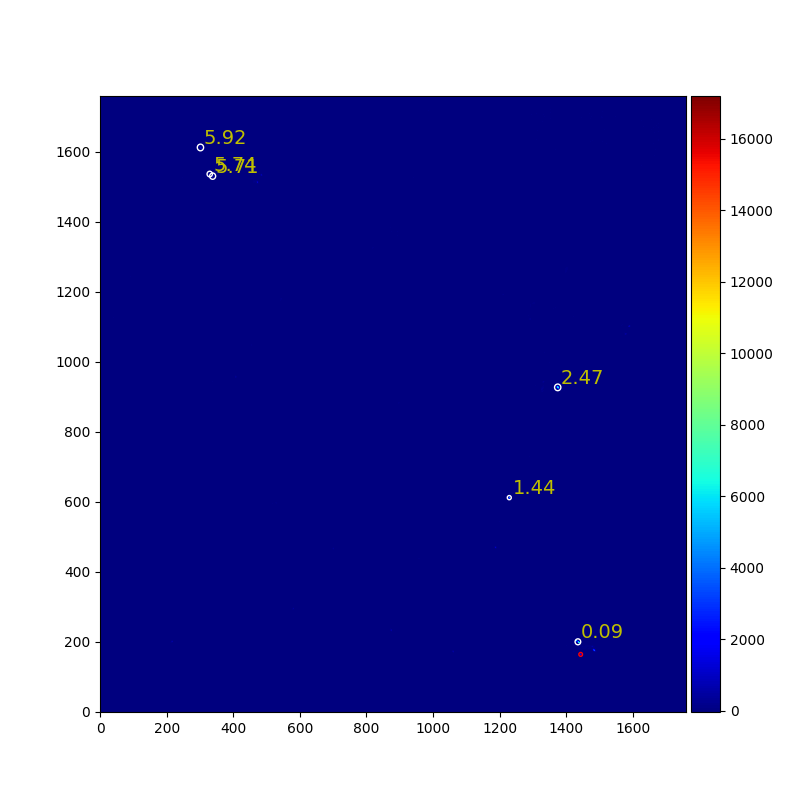

In [334]:
peak_number =specific_shots('r0168', 'LCLS_2011_Mar01_r0168_004818_6ca8_cspad')['No_of_peaks']
Center = specific_shots('r0168', 'LCLS_2011_Mar01_r0168_004818_6ca8_cspad')['center_mass']
Radius = specific_shots('r0168', 'LCLS_2011_Mar01_r0168_004818_6ca8_cspad')['radiusInPixels']
f = h5py.File('/Volumes/harddrive/LCLS/CXI/cxi25410/res/iceFinderCampaign/output_r0168/type1/LCLS_2011_Mar01_r0168_004818_6ca8_cspad.h5', 'r')
d = f['data/data'][:]
fig = plt.figure(figsize=[8,8])
fig = plt.gcf()
ax = fig.gca()

circle1 = plt.Circle(Center[0], Radius[0], color='r')
circle1.set_fill(False)
for peak in range(peak_number):
    if peak != 0:
        circle2 = plt.Circle(Center[peak], radius=Radius[peak], color='w')
        circle2.set_fill(False)
        ax.add_patch(circle2)
        plt.text(Center[peak][0]+10, Center[peak][1]+10, round(dict_ex[tuple(Center[0])][tuple(Center[peak])],2), color = 'y', fontsize = 14)

im = ax.imshow(d,cmap='jet', origin = 'lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax.add_patch(circle1)

fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [138]:
distances = []
min_distances = []
run ='r0144'
shot ='LCLS_2011_Feb28_r0144_163006_2feb_cspad'
run_path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
run_no = h5py.File(run_path,'r')
n_peaks = run_no['shots'][shot]['numberOfPeaks'][()]
dict_q = {}
centre = run_no['shots'][shot]['peakCenterOfMassInPixels'][:]
qcm_x = run_no['shots'][shot]['peakCenterOfMassQx'][()]
qcm_y = run_no['shots'][shot]['peakCenterOfMassQy'][()]
q_cm = list(zip(qcm_x,qcm_y))
dict_q = distance.cdist(q_cm,q_cm)
    #all_dist = [d[np.nonzero(d)]]
    #distances.append(np.array(all_dist).flatten())   
    #try:
    #    min_dist = [np.min(d[np.nonzero(d)])]
    #    min_distances.append(np.array(min_dist).flatten())
    #except:
    #    pass

In [139]:
# this dictionary determines which distance corresponds to which points
dict_ex = {}
for i,j in enumerate(q_cm):
    dict_ex[j] = {}
    for m,k in enumerate(q_cm):
        dict_ex[j][k] = {}
        dict_ex[j][k] = dict_q[i][m]